In [1]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf
import seaborn as sns
from pylab import rcParams
from sklearn import metrics
from sklearn.model_selection import train_test_split
%matplotlib inline
sns.set(style='whitegrid', palette='muted', font_scale=1.5)
rcParams['figure.figsize'] = 14, 8
RANDOM_SEED = 42

/home/kim/anaconda3/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
%%time
%%time
X_train = pd.read_csv("./cleaned_data/train/features/x_train.csv").values
X_test = pd.read_csv("./cleaned_data/test/features/x_test.csv").values
y_train = pd.read_csv("./cleaned_data/train/labels/y_train.csv").values
y_test = pd.read_csv("./cleaned_data/test/labels/y_test.csv").values

CPU times: user 1min 39s, sys: 3.64 s, total: 1min 43s
Wall time: 1min 43s
CPU times: user 1min 39s, sys: 3.64 s, total: 1min 43s
Wall time: 1min 43s


In [3]:
print(f"{X_train.shape}, {X_test.shape}, {y_train.shape}, {y_test.shape}")

(522490, 600), (130622, 600), (522490, 1), (130622, 1)


In [4]:
N_CLASSES = 7
N_HIDDEN_UNITS = 64
N_TIME_STEPS = 200
N_FEATURES=3

In [5]:
X_train = X_train.reshape(len(X_train), N_TIME_STEPS, N_FEATURES)
X_test = X_test.reshape(len(X_test), N_TIME_STEPS, N_FEATURES)

In [6]:
def create_LSTM_model(inputs):
    W = {
        'hidden': tf.Variable(tf.random_normal([N_FEATURES, N_HIDDEN_UNITS])),
        'output': tf.Variable(tf.random_normal([N_HIDDEN_UNITS, N_CLASSES]))
    }
    biases = {
        'hidden': tf.Variable(tf.random_normal([N_HIDDEN_UNITS], mean=1.0)),
        'output': tf.Variable(tf.random_normal([N_CLASSES]))
    }
    
    X = tf.transpose(inputs, [1, 0, 2])
    X = tf.reshape(X, [-1, N_FEATURES])
    hidden = tf.nn.relu(tf.matmul(X, W['hidden']) + biases['hidden'])
    hidden = tf.split(hidden, N_TIME_STEPS, 0)

    # Stack 2 LSTM layers
    lstm_layers = [tf.contrib.rnn.BasicLSTMCell(N_HIDDEN_UNITS, forget_bias=1.0) for _ in range(2)]
    lstm_layers = tf.contrib.rnn.MultiRNNCell(lstm_layers)

    outputs, _ = tf.contrib.rnn.static_rnn(lstm_layers, hidden, dtype=tf.float32)

    # Get output for the last time step
    lstm_last_output = outputs[-1]

    return tf.matmul(lstm_last_output, W['output']) + biases['output']

In [7]:
tf.reset_default_graph()

X = tf.placeholder(tf.float32, [None, N_TIME_STEPS, N_FEATURES], name="input")
Y = tf.placeholder(tf.int64, [None, 1])

In [8]:
pred_Y = create_LSTM_model(X)

pred_softmax = tf.nn.softmax(pred_Y, name="y_")

In [9]:
L2_LOSS = 0.0015

l2 = L2_LOSS * \
    sum(tf.nn.l2_loss(tf_var) for tf_var in tf.trainable_variables())

loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = pred_Y, labels = tf.one_hot(tf.reshape(Y, [-1]), N_CLASSES))) + l2

In [10]:
LEARNING_RATE = 0.0025

optimizer = tf.train.AdamOptimizer(learning_rate=LEARNING_RATE).minimize(loss)

correct_pred = tf.equal(tf.argmax(pred_softmax, 1), tf.argmax(tf.one_hot(tf.reshape(Y, [-1]), N_CLASSES), 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, dtype=tf.float32))

In [12]:
%%time
N_EPOCHS = 50
BATCH_SIZE = 1024
saver = tf.train.Saver()

history = dict(train_loss=[], 
                     train_acc=[], 
                     test_loss=[], 
                     test_acc=[])

sess=tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

train_count = len(X_train)

for i in range(1, N_EPOCHS + 1):
    for start, end in zip(range(0, train_count, BATCH_SIZE),
                          range(BATCH_SIZE, train_count + 1,BATCH_SIZE)):
        sess.run(optimizer, feed_dict={X: X_train[start:end],
                                       Y: y_train[start:end]})
        
    _, acc_train, loss_train = sess.run([pred_softmax, accuracy, loss], feed_dict={
                                            X: X_train, Y: y_train})

    _, acc_test, loss_test = sess.run([pred_softmax, accuracy, loss], feed_dict={
                                            X: X_test, Y: y_test})
    
    print('epoch: {0} test accuracy: {1} loss: {2}'.format(i, acc_test, loss_test))
    print('epoch: {0} train accuracy: {1} loss: {2}'.format(i, acc_train, loss_train))

    history['train_loss'].append(loss_train)
    history['train_acc'].append(acc_train)
    history['test_loss'].append(loss_test)
    history['test_acc'].append(acc_test)

    if i != 1 and i % 10 != 0:
        continue

    print('epoch: {0} test accuracy: {1} loss: {2}'.format(i, acc_test, loss_test))
    
predictions, acc_final, loss_final = sess.run([pred_softmax, accuracy, loss], feed_dict={X: X_test, Y: y_test})

print()
print('final results: accuracy: {0} loss: {1}'.format(acc_final, loss_final))

epoch: 1 test accuracy: 0.7544977068901062 loss: 1.1721794605255127
epoch: 1 train accuracy: 0.7527761459350586 loss: 1.1733698844909668
epoch: 1 test accuracy: 0.7544977068901062 loss: 1.1721794605255127
epoch: 2 test accuracy: 0.816049337387085 loss: 0.8827394247055054
epoch: 2 train accuracy: 0.8150050640106201 loss: 0.882713794708252
epoch: 3 test accuracy: 0.8446356654167175 loss: 0.7315198183059692
epoch: 3 train accuracy: 0.8438572883605957 loss: 0.7317976951599121
epoch: 4 test accuracy: 0.855560302734375 loss: 0.6630815267562866
epoch: 4 train accuracy: 0.8552374243736267 loss: 0.6622980833053589
epoch: 5 test accuracy: 0.862052321434021 loss: 0.6157117486000061
epoch: 5 train accuracy: 0.8620700836181641 loss: 0.6141660213470459
epoch: 6 test accuracy: 0.8616236448287964 loss: 0.5957746505737305
epoch: 6 train accuracy: 0.8624241352081299 loss: 0.5937450528144836
epoch: 7 test accuracy: 0.8701596856117249 loss: 0.5661356449127197
epoch: 7 train accuracy: 0.8696587681770325 lo

In [13]:
pickle.dump(predictions, open("predictions.p", "wb"))
pickle.dump(history, open("history.p", "wb"))
tf.train.write_graph(sess.graph_def, '.', 'checkpoint/har.pbtxt')  
saver.save(sess, save_path = "./checkpoint/har.ckpt")
sess.close()

In [14]:
history = pickle.load(open("history.p", "rb"))
predictions = pickle.load(open("predictions.p", "rb"))

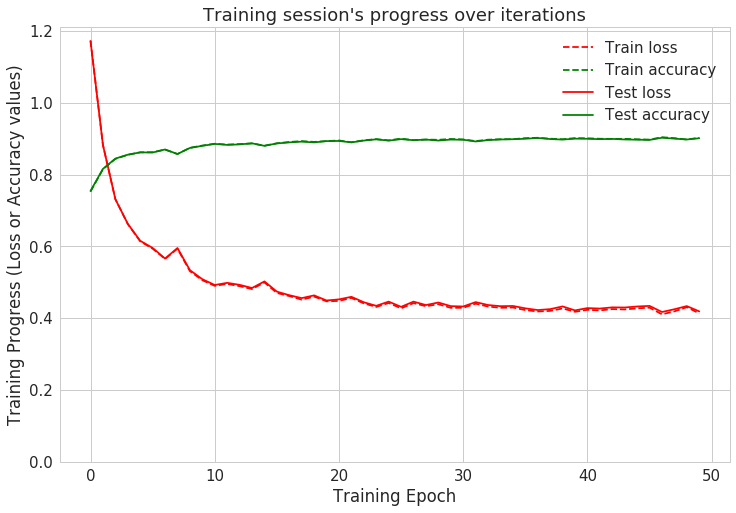

In [15]:
plt.figure(figsize=(12, 8))
plt.plot(np.array(history['train_loss']), "r--", label="Train loss")
plt.plot(np.array(history['train_acc']), "g--", label="Train accuracy")
plt.plot(np.array(history['test_loss']), "r-", label="Test loss")
plt.plot(np.array(history['test_acc']), "g-", label="Test accuracy")
plt.title("Training session's progress over iterations")
plt.legend(loc='upper right', shadow=True)
plt.ylabel('Training Progress (Loss or Accuracy values)')
plt.xlabel('Training Epoch')
plt.ylim(0)
plt.show()

In [17]:
from tensorflow.python.tools import freeze_graph

MODEL_NAME = 'har'

input_graph_path = 'checkpoint/' + MODEL_NAME+'.pbtxt'
checkpoint_path = './checkpoint/' +MODEL_NAME+'.ckpt'
restore_op_name = "save/restore_all"
filename_tensor_name = "save/Const:0"
output_frozen_graph_name = 'frozen_'+MODEL_NAME+'.pb'

freeze_graph.freeze_graph(input_graph_path, input_saver="",
                          input_binary=False, input_checkpoint=checkpoint_path, 
                          output_node_names="y_", restore_op_name="save/restore_all",
                          filename_tensor_name="save/Const:0", 
                          output_graph=output_frozen_graph_name, clear_devices=True, initializer_nodes="")

INFO:tensorflow:Restoring parameters from ./checkpoint/har.ckpt
INFO:tensorflow:Froze 8 variables.
Converted 8 variables to const ops.
